In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Things needs from cco file
### A dataframe with
- nVessels rows and in the columns
    - node in, node out
    - Radius
    - [Optional] Flow computed by cco 
    - Daughter of current vessels row number
    - A branch number depending on the inlet they are attached to


In [112]:
def ReadCCO(CCOFileName):
    
    tmpDFVessels = pd.DataFrame([], columns=['Radius', 'ParentIdx', 'BranchesIdx','Flow','Stage', 'Inlet', 'TerminalCap'])
    tmpDFNodes  = pd.DataFrame([], columns=['xProx', 'xDist'])
    
    with open(CCOFileName) as f:
        
        f.readline()
        f.readline()
        f.readline() 
        
        f.readline()
        nVessels = int(f.readline())
        print(f'Found {nVessels} in the initial tree.')\
       
        for i in range(nVessels):
            vessel = f.readline().split() 
            idx, r, flow, stage = int(vessel[0]), max(float(vessel[12]), 4e-4), float(vessel[13]), int(vessel[-1])
            xProx, xDist        = np.array(vessel[1:4]).astype(float), np.array(vessel[4:7]).astype(float)
            
            # Keep vessel only if within FOV
            if stage>-2:
                tmpDFVessels.at[idx,'Radius'] = r
                tmpDFVessels.at[idx,'Flow']   = flow
                tmpDFVessels.at[idx,'Stage']  = stage
                tmpDFNodes.at[idx] = [xProx, xDist]
        
        f.readline()
        f.readline()
        idxToKeep = tmpDFVessels.index
        for i in range(nVessels):
            vessel = f.readline().split()
            idx, parentIdx, branchesIdx = int(vessel[0]), int(vessel[1]), [int(b) for b in vessel[2:]]
            
            if idx in idxToKeep:
                tmpDFVessels.at[idx, 'ParentIdx']  = parentIdx
                tmpDFVessels.at[idx, 'BranchesIdx'] = branchesIdx
                
                if not parentIdx in idxToKeep:
                    tmpDFVessels.at[idx, 'Inlet'] = True
                elif not branchesIdx:
                    tmpDFVessels.at[idx, 'TerminalCap'] = True
                else:
                    tmpDFVessels.at[idx, 'Inlet'] = False
                    tmpDFVessels.at[idx, 'TerminalCap'] = False
            
    # Create the nodes list and connection table
    nVessels   = tmpDFVessels.shape[0]
    inletIdx   = tmpDFVessels[tmpDFVessels.Inlet==True].index 
    termCapIdx = tmpDFVessels[tmpDFVessels.TerminalCap==True].index
    nInlets, nTermCap = len(inletIdx), len(termCapIdx)
    arterioles = np.arange(nInlets)
    np.random.shuffle(arterioles)
    arterioles = arterioles[:int(round(nInlets/2.0))]

    
    print(f'Kept {nVessels} in the final tree, with {nInlets} inlets and {nTermCap} terminal capillaries.')
    print(f'Branch numbers {arterioles}, will be counted as arterioles.')
    
    df = pd.DataFrame([], columns=['NodeIn', 'NodeOut', 'Radius', 'Flow', 'BranchNumber','Arteriole', 'xProx', 'xDist'])
    
    def BuildNodeListAndAssignBranchNumber(inletIdx, currentNodeIdx, branchNumber):
            
            if branchNumber in arterioles:
                nodeIn, nodeOut = currentNodeIdx, currentNodeIdx+1
            else:
                nodeIn, nodeOut = currentNodeIdx+1, currentNodeIdx
            
            df.at[inletIdx] = [nodeIn, nodeOut,
                               tmpDFVessels.at[inletIdx,'Radius'],
                               tmpDFVessels.at[inletIdx,'Flow'],
                               branchNumber,
                               branchNumber in arterioles,
                               tmpDFNodes.at[inletIdx, 'xProx'].tolist(),
                               tmpDFNodes.at[inletIdx, 'xDist'].tolist()
                              ]

            for branch in tmpDFVessels.at[inletIdx,'BranchesIdx']:
                BuildNodeListAndAssignBranchNumber(branch, currentNodeIdx+1, branchNumber)
    
    currentNodeIdx = 0
    
    for branchNumber, inlet in enumerate(inletIdx):
        
        BuildNodeListAndAssignBranchNumber(inlet, currentNodeIdx, branchNumber)
        currentNodeIdx = df.NodeOut.max()
 
    
    ''' Create the connection between terminal capillaries. 
        Terminal arteriolar capillaries are linked to the 
        closest terminal venous capillary. '''
    venousCap = df[df.Arteriole==False].index
    venousCapCandidates = [int(cap) for cap in venousCap] 
    arteriolarCap = df[df.Arteriole==True].index
    usedAllVenousCap = False
    newVesselIdx = df.index.max()

    for artCapIdx in arteriolarCap:
        
        # Find closest terminal node in the venous tree 
        if not venousCapCandidates:
            venousCapCandidates = [int(cap) for cap in venousCap] # If we have exhausted
                                                                  # the terminal capillaries in the venous tree, 
            usedAllVenousCap = True         # we allow more than a single connection to each  
        nodeOutArt = tmpDFNodes.at[artCapIdx,'xDist'] 
        
        candidatesNodes = tmpDFNodes.loc[venousCapCandidates].xProx
        candidatesIdx   = candidatesNodes.index
        positions = np.array([list(x) for x in candidatesNodes.values])
        distances = np.linalg.norm(nodeOutArt-positions, axis=1)
        chosenCapIdx = candidatesIdx[distances.argmin()]
        venousCapCandidates.remove(chosenCapIdx) # Remove the chosen node from the list
        
        # Create a link between the two nodes
        newVesselIdx +=1
        df.at[newVesselIdx] = [df.at[artCapIdx,'NodeOut'], df.at[chosenCapIdx,'NodeIn'],
                               4.0e-4, 0.0, -1, None,
                               df.at[artCapIdx,'xDist'],
                               df.at[chosenCapIdx,'xProx']
                              ] # Branch number = -1 for connecting vessels added at this stage
        
        
    if not usedAllVenousCap:
        for venCapIdx in venousCapCandidates:
            
            nodeInVen = tmpDFNodes.at[venCapIdx,'xProx']
            candidatesNodes = tmpDFNodes.loc[arteriolarCap].xDist
            candidatesIdx = candidatesNodes.index
         
            positions = np.array([list(x) for x in candidatesNodes.values])
            distances = np.linalg.norm(nodeOutArt-positions, axis=1)
            newVesselIdx+=1
            df.at[newVesselIdx] = [df.at[chosenCapIdx,'NodeOut'], df.at[venCapIdx,'NodeIn'],
                                   4.0e-4, 0.0, -2, None,
                                   df.at[chosenCapIdx,'xDist'],
                                   df.at[venCapIdx,'xProx']
                                  ] # Branch number = -2 for connecting vessels added at this stage

        

    
    ## Connection table
    df = df.reset_index(drop=False)
    nNodes   = max(df.NodeIn.max(), df.NodeOut.max()) + 1 
    nVessels = df.shape[0] 
    C = np.zeros((nNodes,nVessels))
    for i,row in df.iterrows():
        nodeIn, nodeOut = row.NodeIn, row.NodeOut
        C[nodeIn,i]  = 1
        C[nodeOut,i] = -1
        
    
    return C, df

In [117]:
C, df = ReadCCO('20TerminalVessels.cco')
df

Found 154 in the initial tree.
Kept 105 in the final tree, with 7 inlets and 27 terminal capillaries.
Branch numbers [2 3 6 5], will be counted as arterioles.


/home/remi/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/remi/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/remi/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths

,index,NodeIn,NodeOut,Radius,Flow,BranchNumber,Arteriole,xProx,xDist
0,23,1,0,0.002012,1.37931,0,False,"[0.095, 0.149, 0.0]","[0.095, 0.143, 0.0]"
1,24,2,1,0.002012,1.37931,0,False,"[0.095, 0.143, 0.0]","[0.09383333333333334, 0.14066666666666666, 0.0]"
2,120,3,2,0.001236,0.344828,0,False,"[0.09383333333333334, 0.14066666666666666, 0.0]","[0.14948543906211853, 0.1349031627178192, 0.0]"
3,121,3,2,0.00182,1.034483,0,False,"[0.09383333333333334, 0.14066666666666666, 0.0]","[0.088, 0.12900000000000003, 0.0]"
4,25,4,3,0.00182,1.034483,0,False,"[0.088, 0.12900000000000003, 0.0]","[0.092, 0.11800000000000002, 0.0]"
...,...,...,...,...,...,...,...,...,...
161,210,78,44,0.0004,0.0,-1,None,"[-0.03799999999999999, -0.06499999999999999, 0.0]","[0.10700000000000001, -0.076, 0.0]"
162,211,79,53,0.0004,0.0,-1,None,"[-0.03516666666666666, -0.06416666666666666, 0.0]","[0.091, 0.0030000000000000027, 0.0]"
163,212,80,14,0.0004,0.0,-1,None,"[-0.04061727598309517, -0.012431461364030838, ...","[0.017000000000000015, 0.095, 0.0]"
164,213,80,54,0.0004,0.0,-1,None,"[-0.02099999999999999, -0.06, 0.0]","[0.0905, 0.004333333333333337, 0.0]"


In [114]:
print(df[df.BranchNumber==-1].shape[0], df[df.BranchNumber==-2].shape[0])

388 187


In [118]:
nodeList = np.zeros(C.shape[0])
for i,row in df.iterrows():
    nodeIn, nodeOut = row.NodeIn, row.NodeOut
    nodeList[nodeIn]+=1
    nodeList[nodeOut]+=1
print(C.shape, 'Too many segments for too few nodes. Must have wrote over existing nodes somehow.')

(82, 166) Too many segments for too few nodes. Must have wrote over existing nodes somehow.


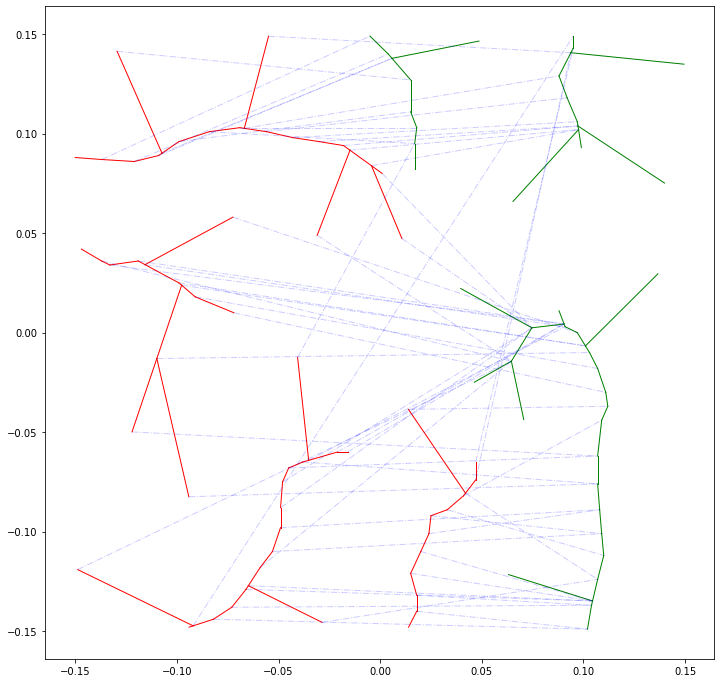

In [119]:
fig = plt.figure(figsize=(12,12))

for i, row in df.iterrows():
    xDist, xProx = row.xDist, row.xProx
    x,y = [xProx[0], xDist[0]], [xProx[1], xDist[1]]
    color, alpha = '-.b', 0.2
    if row.Arteriole:
        color, alpha = 'r', 1
    elif row.Arteriole==False:
        color, alpha = 'g', 1
    plt.plot(x,y, color, linewidth=1, alpha=alpha)
    
fig.savefig('PlotOfNetwork.jpg')